In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
from sklearn import neighbors

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'

In [5]:
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features/extracted-features.sqlite".format(EXPERIMENT_DIR)
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)


In [6]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


In [7]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
seq_df = pd.read_sql_query('select sequence,charge,file_idx,intensity,peak_proportion_intensity,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,human,number_of_runs_extracted from features where (rt_apex is not null) and (scan_apex is not null)', db_conn)
db_conn.close()


In [8]:
seq_df['intensity_log'] = np.log2(seq_df.intensity)

In [9]:
# find the experiment-wide mean of intensity
experiment_means_l = []
for group_name,group_df in seq_df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_log_mean = np.mean(group_df.intensity_log)
    experiment_intensity_mean = np.mean(group_df.intensity)

    experiment_intensity_log_median = np.median(group_df.intensity_log)
    experiment_intensity_median = np.median(group_df.intensity)

    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_means_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_log_mean,experiment_intensity_median,experiment_intensity_log_median))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_log_mean','experiment_intensity_median','experiment_intensity_log_median'])


In [10]:
sequences_df = pd.merge(seq_df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [11]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity',
       'peak_proportion_intensity', 'monoisotopic_mass',
       'monoisotopic_mz_centroid', 'rt_apex', 'scan_apex', 'run_name', 'batch',
       'human', 'number_of_runs_extracted', 'intensity_log',
       'experiment_intensity_mean', 'experiment_intensity_log_mean',
       'experiment_intensity_median', 'experiment_intensity_log_median'],
      dtype='object')

In [56]:
sequences_df['delta_intensity_log'] = sequences_df.intensity_log - sequences_df.experiment_intensity_log_median


In [57]:
sequences_df[['intensity','experiment_intensity_log_mean','delta_intensity_log']].sample(5)

,intensity,experiment_intensity_log_mean,delta_intensity_log
139948,6193,13.006537,-0.259723
7900,2918,11.863157,-0.369545
141892,3498,11.576422,0.166808
75323,1884,10.255515,0.386729
46152,1625,11.095853,-0.549958


In [14]:
run_name = '190719_Hela_Ecoli_1to1_01'
file_idx = file_idx_for_run(run_name)

In [15]:
minimum_number_of_runs_for_training_set = 5

In [16]:
sequences_selected_run_df = sequences_df[(sequences_df.file_idx == file_idx)].copy()


#### use a kNN model to predict the effect on intensity of m/z, CCS, and RT

In [17]:
from sklearn import preprocessing

In [18]:
training_attributes = ['monoisotopic_mz_centroid','rt_apex','scan_apex']

In [19]:
X_train = sequences_selected_run_df[training_attributes].values
y_train = sequences_selected_run_df[['delta_intensity_log']].values[:,0]

In [20]:
# scaler_X = preprocessing.StandardScaler().fit(X_train)
# scaler_X = preprocessing.Normalizer().fit(X_train)
scaler_X = preprocessing.RobustScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)

In [21]:
knn = neighbors.KNeighborsRegressor(n_neighbors=80, weights='uniform')
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=80, p=2,
                    weights='uniform')

In [22]:
X = sequences_selected_run_df[training_attributes].values
X_scaled = scaler_X.transform(X)

In [23]:
predicted_delta_intensity_log = knn.predict(X_scaled)
predicted_delta_intensity_log

array([-0.00842887,  0.0634427 , -0.07219257, ..., -0.04209448,
       -0.0159615 , -0.12461997])

In [24]:
sequences_selected_run_df['predicted_delta_intensity_log'] = predicted_delta_intensity_log
sequences_selected_run_df['predicted_delta_intensity'] = np.power(2, sequences_selected_run_df.predicted_delta_intensity_log)
sequences_selected_run_df['normalised_intensity'] = sequences_selected_run_df.intensity - sequences_selected_run_df.predicted_delta_intensity


In [25]:
sequences_selected_run_df[['sequence','charge','intensity','experiment_intensity_mean','predicted_delta_intensity_log','normalised_intensity']].sample(5)

,sequence,charge,intensity,experiment_intensity_mean,predicted_delta_intensity_log,normalised_intensity
188113,EEAQAEIEQYR,2,465,3107.200000,-0.184042,464.119767
199650,QLGISSHENATPVK,2,1109,870.000000,-0.001460,1108.001012
194504,ITLECLPQNVGFYK,2,2490,3003.300000,-0.099256,2489.066486
206614,YLFPEDPSYSSTMIDDEALK,2,596,774.666667,0.263448,594.799656
196939,LSDGIGVMLPQVLK,2,3133,2692.300000,0.089528,3131.935978


In [26]:
mean_delta_l = []
for group_name,group_df in sequences_selected_run_df.groupby(['rt_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['rt_apex','mean_predicted_delta_intensity_log'])

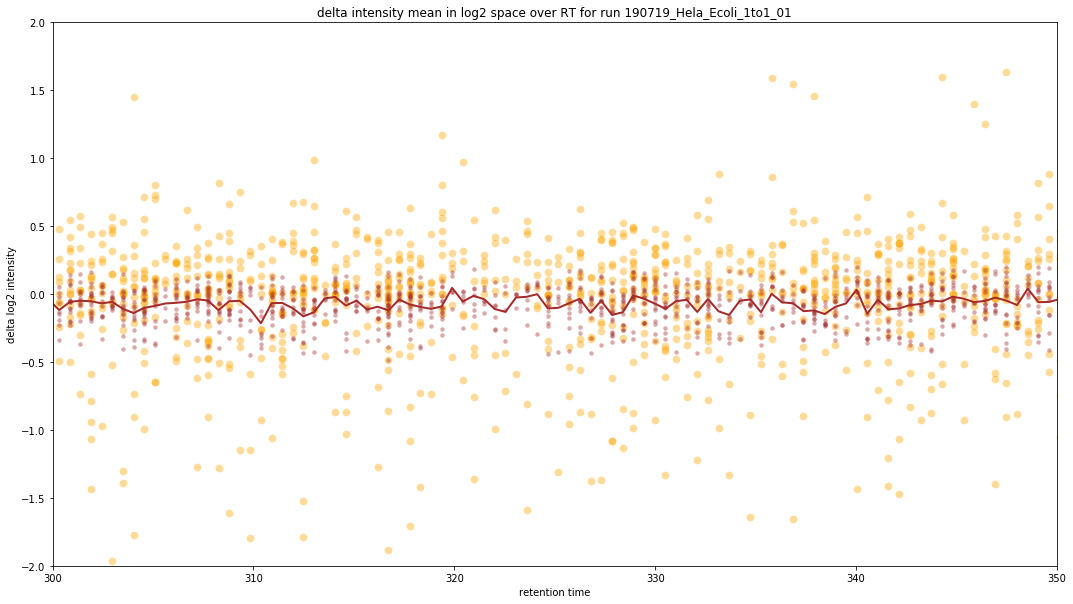

In [27]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequences_selected_run_df.rt_apex, sequences_selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(sequences_selected_run_df.rt_apex, predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.rt_apex, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

In [28]:
mean_delta_l = []
for group_name,group_df in sequences_selected_run_df.groupby(['scan_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['scan_apex','mean_predicted_delta_intensity_log'])

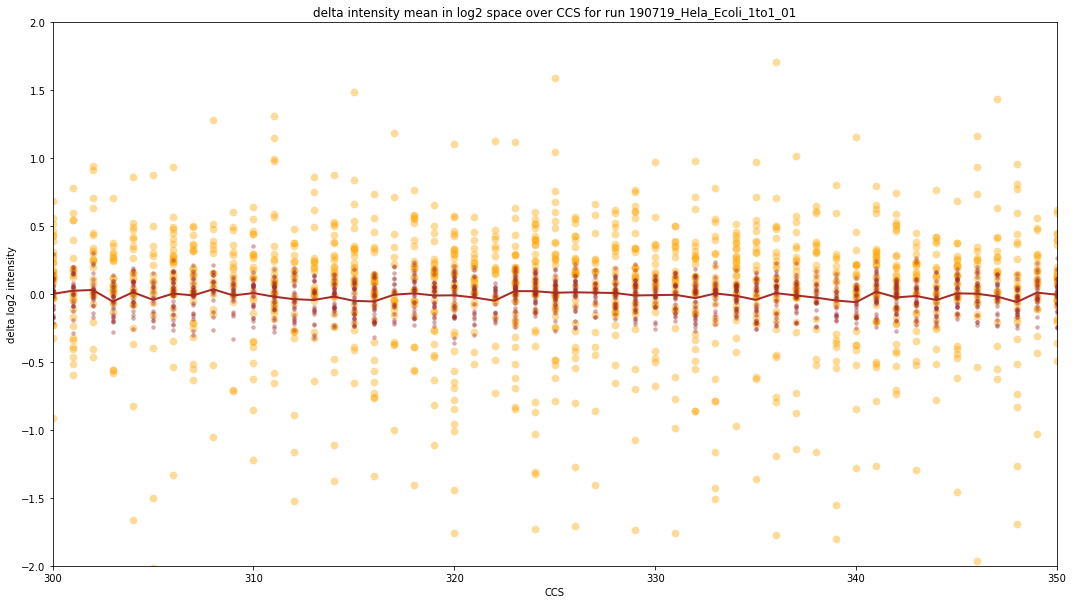

In [29]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequences_selected_run_df.scan_apex, sequences_selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(sequences_selected_run_df.scan_apex, predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.scan_apex, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

In [30]:
mean_delta_l = []
sequences_selected_run_df['mz_truncated'] = sequences_selected_run_df.monoisotopic_mz_centroid.astype(int)
for group_name,group_df in sequences_selected_run_df.groupby(['mz_truncated'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['monoisotopic_mz_centroid','mean_predicted_delta_intensity_log'])

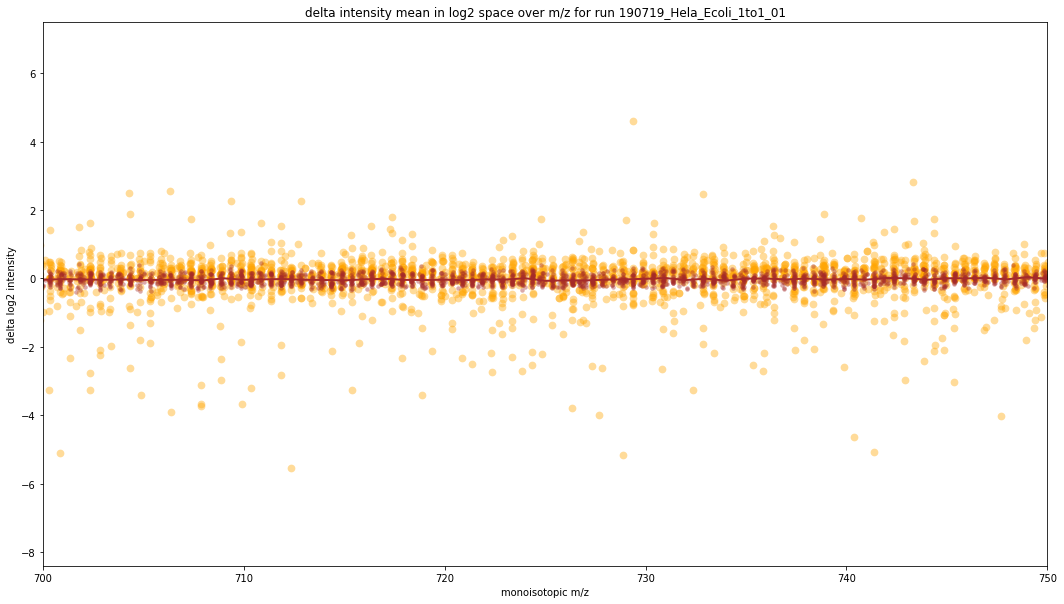

In [31]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(sequences_selected_run_df.monoisotopic_mz_centroid, sequences_selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(sequences_selected_run_df.monoisotopic_mz_centroid, predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.monoisotopic_mz_centroid, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over m/z for run {}'.format(run_name))
plt.xlim((700,750))
# plt.ylim((-2,2))

plt.show()

In [32]:
number_of_neighbours = 10

In [33]:
run_df_l = []
for group_name,group_df in sequences_df.groupby(['file_idx'], as_index=False):
    # get the training set for this run
    sequences_selected_run_df = sequences_df[sequences_df.file_idx == int(group_name)].copy()
    training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= minimum_number_of_runs_for_training_set)]
    X_train = training_set_selected_run_df[training_attributes].values
    y_train = training_set_selected_run_df[['delta_intensity_log']].values[:,0]
    # scale the training set input values
    scaler_X = preprocessing.RobustScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    # fit the model
    knn = neighbors.KNeighborsRegressor(n_neighbors=number_of_neighbours, weights='uniform')
    _ = knn.fit(X_train_scaled, y_train)
    # scale the input values
    X = sequences_selected_run_df[training_attributes].values
    X_scaled = scaler_X.transform(X)
    # estimate the delta intensity
    sequences_selected_run_df['predicted_delta_intensity_log'] = knn.predict(X_scaled)
    sequences_selected_run_df['predicted_delta_intensity'] = np.power(2, sequences_selected_run_df.predicted_delta_intensity_log)
    sequences_selected_run_df['normalised_intensity'] = sequences_selected_run_df.intensity - sequences_selected_run_df.predicted_delta_intensity
    # add it to the list of runs
    run_df_l.append(sequences_selected_run_df)

normalised_sequences_df = pd.concat(run_df_l, axis=0, sort=False)


In [34]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in normalised_sequences_df.groupby(['sequence','charge']):
    if len(group_df) == 10:
        intensity_cv = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])


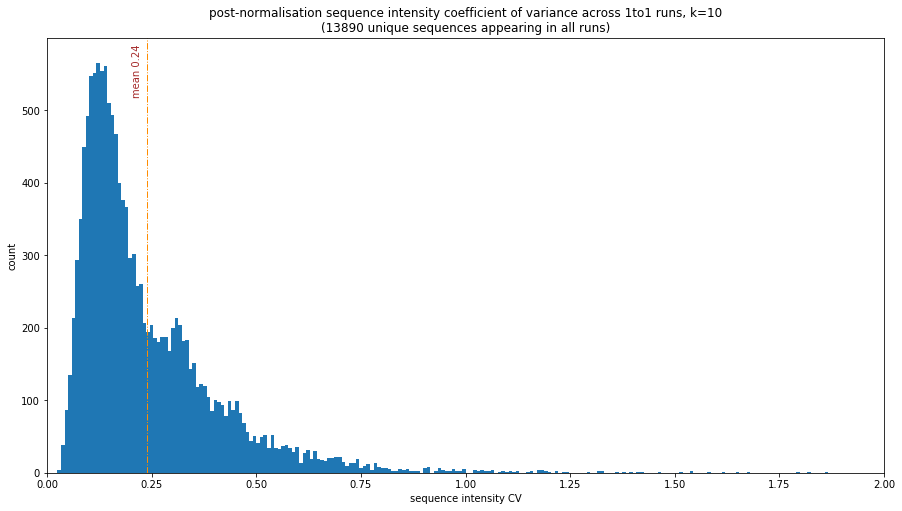

In [35]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('post-normalisation sequence intensity coefficient of variance across 1to1 runs, k={}\n({} unique sequences appearing in all runs)'.format(number_of_neighbours, len(sequence_cv_df)))
plt.xlim((0,2))

plt.show()

In [36]:
normalised_sequences_df.to_csv('/Users/darylwilding-mcbride/Downloads/normalised_sequences.csv', index=False)

In [47]:
number_of_neighbours_to_try = [2,5,8,10,20,50,100]

In [48]:
sequence_cv_df_l = []
for idx,number_of_neighbours in enumerate(number_of_neighbours_to_try):
    run_df_l = []
    for group_name,group_df in sequences_df.groupby(['file_idx'], as_index=False):
        # get the training set for this run
        sequences_selected_run_df = sequences_df[sequences_df.file_idx == int(group_name)].copy()
        training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= minimum_number_of_runs_for_training_set)]
        X_train = training_set_selected_run_df[training_attributes].values
        y_train = training_set_selected_run_df[['delta_intensity_log']].values[:,0]
        # scale the training set input values
        scaler_X = preprocessing.RobustScaler().fit(X_train)
        X_train_scaled = scaler_X.transform(X_train)
        # fit the model
        knn = neighbors.KNeighborsRegressor(n_neighbors=number_of_neighbours, algorithm='kd_tree', weights='distance')
        _ = knn.fit(X_train_scaled, y_train)
        # scale the input values
        X = sequences_selected_run_df[training_attributes].values
        X_scaled = scaler_X.transform(X)
        # estimate the delta intensity
        sequences_selected_run_df['predicted_delta_intensity_log'] = knn.predict(X_scaled)
        sequences_selected_run_df['predicted_delta_intensity'] = np.power(2, sequences_selected_run_df.predicted_delta_intensity_log)
        sequences_selected_run_df['normalised_intensity'] = sequences_selected_run_df.intensity - sequences_selected_run_df.predicted_delta_intensity
        # add it to the list of runs
        run_df_l.append(sequences_selected_run_df)

    normalised_sequences_df = pd.concat(run_df_l, axis=0, sort=False)

    # for each sequence, find the CV
    sequence_cv_l = []
    for group_name,group_df in normalised_sequences_df.groupby(['sequence','charge']):
        if len(group_df) == 10:
            intensity_cv = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
            sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
    sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])
    sequence_cv_df_l.append(sequence_cv_df)
    print("min: {}, max: {}".format(sequence_cv_df.intensity_cv.min(), sequence_cv_df.intensity_cv.max()))


min: 0.02466140431683346, max: 2.570662554265173
min: 0.02466140431683346, max: 2.570662554265173
min: 0.02466140431683346, max: 2.570662554265173
min: 0.02466140431683346, max: 2.570662554265173
min: 0.02466140431683346, max: 2.570662554265173
min: 0.02466140431683346, max: 2.570662554265173
min: 0.02466140431683346, max: 2.570662554265173


In [66]:
number_of_neighbours = 10

# get the training set for this run
sequences_selected_run_df = sequences_df[sequences_df.file_idx == 1].copy()
training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= minimum_number_of_runs_for_training_set)]
sample_size = int(1.0 * len(training_set_selected_run_df))
training_set_selected_run_df = training_set_selected_run_df.sample(n=sample_size)

X_train = training_set_selected_run_df[training_attributes].values
y_train = training_set_selected_run_df[['delta_intensity_log']].values[:,0]

# fit the model
knn = neighbors.KNeighborsRegressor(n_neighbors=number_of_neighbours, algorithm='kd_tree', weights='distance')
_ = knn.fit(X_train, y_train)

X = sequences_selected_run_df[training_attributes].values

# estimate the delta intensity
sequences_selected_run_df['predicted_delta_intensity_log'] = knn.predict(X)
sequences_selected_run_df['predicted_delta_intensity'] = np.power(2, sequences_selected_run_df.predicted_delta_intensity_log)
sequences_selected_run_df['normalised_intensity'] = sequences_selected_run_df.intensity - sequences_selected_run_df.predicted_delta_intensity


In [67]:
sequences_selected_run_df[['sequence','charge','intensity','experiment_intensity_median','delta_intensity_log','predicted_delta_intensity_log','predicted_delta_intensity','normalised_intensity']].sample(5)

,sequence,charge,intensity,experiment_intensity_median,delta_intensity_log,predicted_delta_intensity_log,predicted_delta_intensity,normalised_intensity
94339,AVGDGVAVKPTDK,2,6733,6856.0,-0.025885,-0.269189,0.829786,6732.170214
115550,YQVSWSLDHK,2,2835,2835.0,0.000000,-0.211138,0.863856,2834.136144
102905,IQFDEGYDNYPGQEK,2,1463,1486.5,-0.022809,-0.022809,0.984314,1462.015686
97620,ENSTHFSQPNSTK,2,300,691.0,-1.203723,-1.203723,0.434153,299.565847
113382,VGEATETALTCLVEK,2,5079,4598.0,0.143538,0.143538,1.104611,5077.895389


In [104]:
sequences_selected_run_df['adjustment'] = sequences_selected_run_df.intensity - sequences_selected_run_df.normalised_intensity

In [107]:
sequences_selected_run_df.adjustment.max(), sequences_selected_run_df.adjustment.mean(), sequences_selected_run_df.adjustment.std()

(129.7194890028477, 1.2187922039146248, 1.4078347151950679)

#### plot the normalised intensity to compare the 1to1 and 1to3

In [88]:
df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/extracted-features/extracted-features.csv')

In [90]:
df['intensity_log'] = np.log2(df.intensity)

In [91]:
# find the experiment-wide mean of intensity
experiment_means_l = []
for group_name,group_df in df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_log_mean = np.mean(group_df.intensity_log)
    experiment_intensity_mean = np.mean(group_df.intensity)

    experiment_intensity_log_median = np.median(group_df.intensity_log)
    experiment_intensity_median = np.median(group_df.intensity)

    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_means_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_log_mean,experiment_intensity_median,experiment_intensity_log_median))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_log_mean','experiment_intensity_median','experiment_intensity_log_median'])


In [92]:
df = pd.merge(df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [93]:
df['delta_intensity_log'] = df.intensity_log - df.experiment_intensity_log_median

In [94]:
NUMBER_OF_RUNS = df.number_of_runs_extracted.max()
NUMBER_OF_RUNS

20

In [95]:
MINIMUM_NUMBER_OF_RUNS = int(NUMBER_OF_RUNS / 2)
NUMBER_OF_1TO1_RUNS = 10
NUMBER_OF_1TO3_RUNS = 10

#### before normalisation

In [77]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [78]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [79]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [80]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

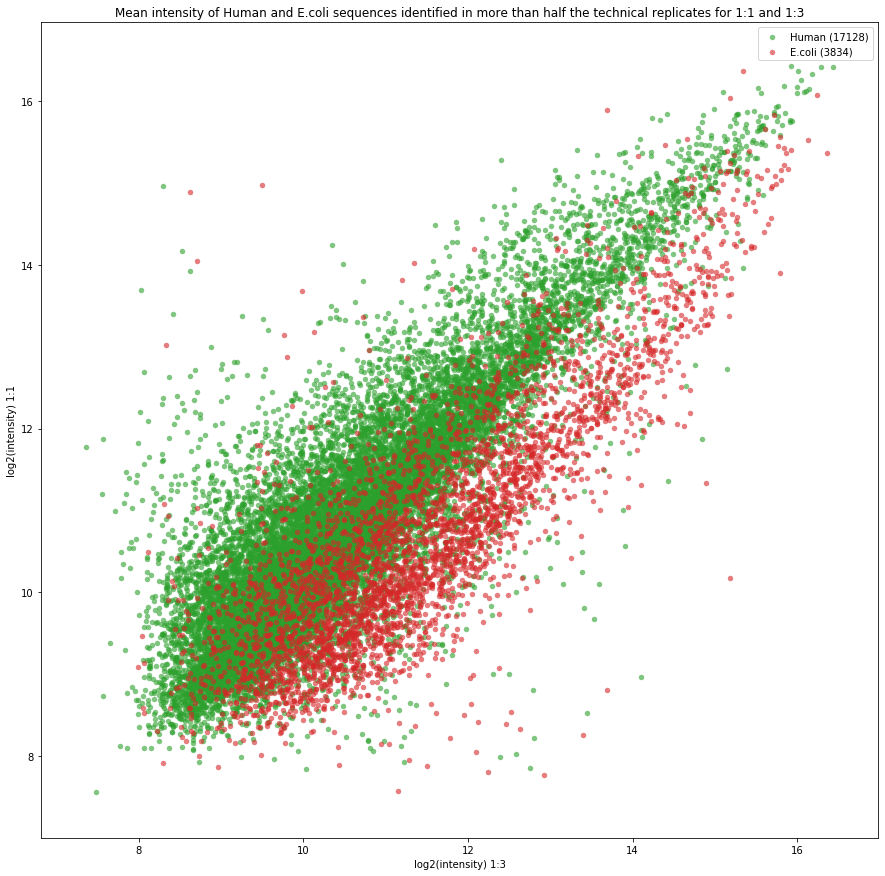

In [81]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

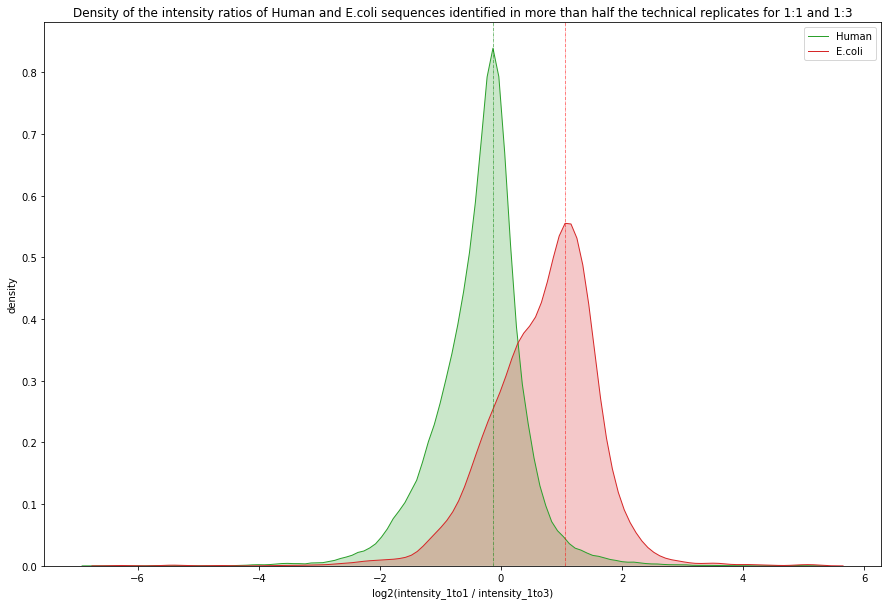

In [82]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

#### normalise intensity

In [96]:
number_of_neighbours = 10

run_df_l = []
for file_idx in df.file_idx.unique():
    # get the training set for this run
    sequences_selected_run_df = df[df.file_idx == file_idx].copy()
    training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= minimum_number_of_runs_for_training_set)]
    sample_size = int(1.0 * len(training_set_selected_run_df))
    training_set_selected_run_df = training_set_selected_run_df.sample(n=sample_size)

    X_train = training_set_selected_run_df[training_attributes].values
    y_train = training_set_selected_run_df[['delta_intensity_log']].values[:,0]

    # fit the model
    knn = neighbors.KNeighborsRegressor(n_neighbors=number_of_neighbours, algorithm='kd_tree', weights='distance')
    _ = knn.fit(X_train, y_train)

    X = sequences_selected_run_df[training_attributes].values

    # estimate the delta intensity
    sequences_selected_run_df['predicted_delta_intensity_log'] = knn.predict(X)
    sequences_selected_run_df['predicted_delta_intensity'] = np.power(2, sequences_selected_run_df.predicted_delta_intensity_log)
    sequences_selected_run_df['normalised_intensity'] = sequences_selected_run_df.intensity - sequences_selected_run_df.predicted_delta_intensity
    run_df_l.append(sequences_selected_run_df)

normalised_experiment_df = pd.concat(run_df_l, axis=0, sort=False)


#### after normalisation

In [98]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in normalised_experiment_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.normalised_intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.normalised_intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [99]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [100]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [101]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

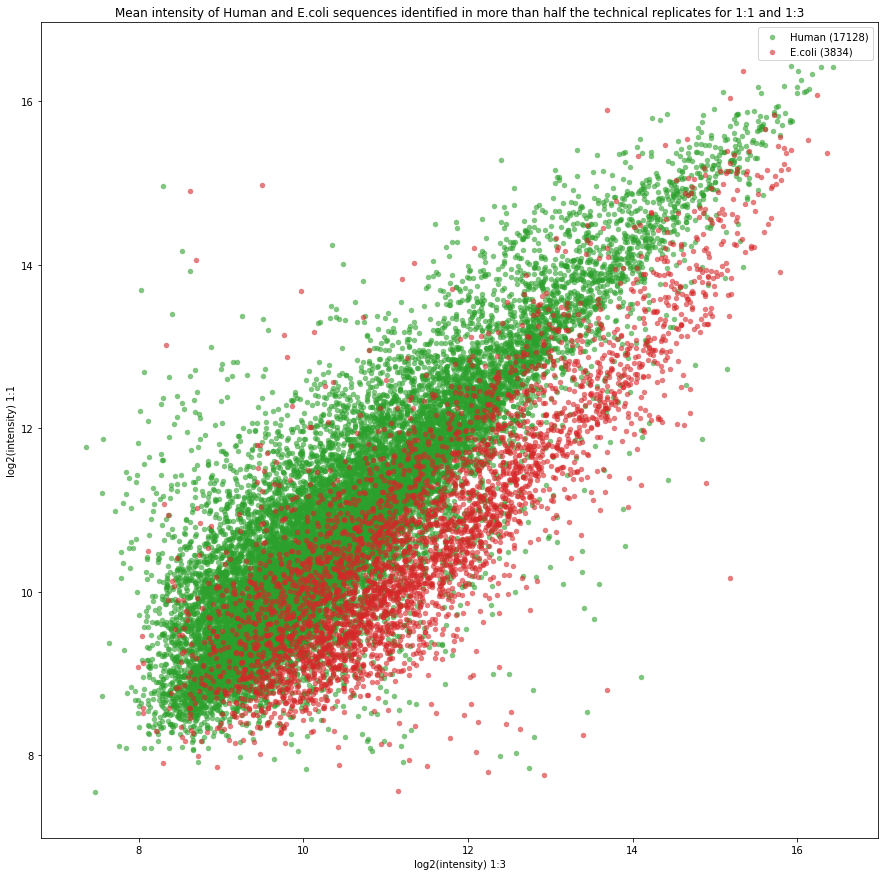

In [102]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

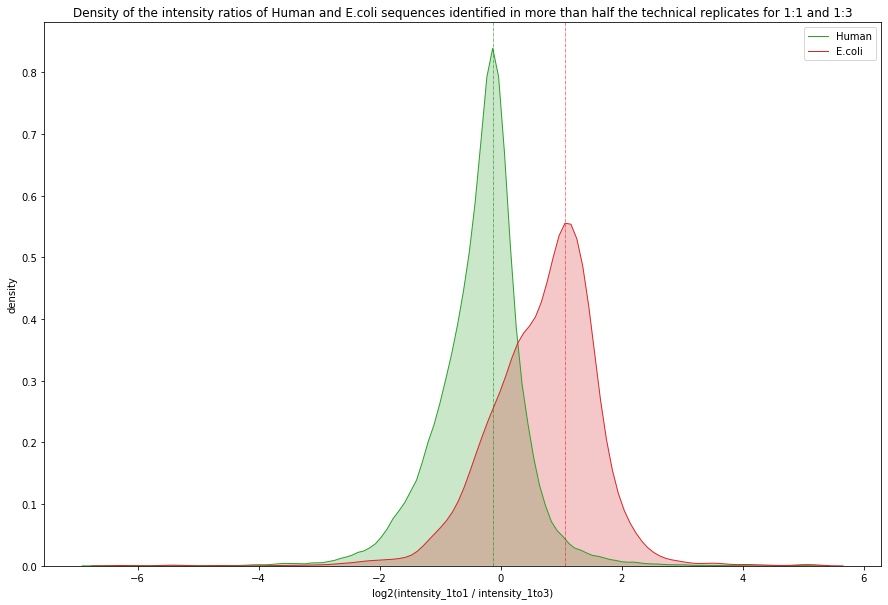

In [103]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')